In [ ]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk # 텍스트 데이터를 처리
import numpy as np # 말뭉치를 배열로 표현
import random
import operator
import string # 표준 파이썬 문자열을 처리

from sklearn.metrics.pairwise import cosine_similarity # 이를 나중에 사용하여 두 개의 문장이 얼마나 비슷한지를 결정합니다.
from sklearn.feature_extraction.text import TfidfVectorizer # Experience 2에서 단어 가방을 만드는 함수를 만들었던 것을 기억하십니까? 이 함수는 같은 일을 합니다!


from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # LogisticRegression import 추가

import os
import numpy as np
from google.colab import drive

In [ ]:
# 구글 드라이브 마운트
drive.mount('/content/drive')
def loadfile(path):
    X = []
    Y = []
    for label in ('0', '25', '50', '75', '100'):
        print("Loading text files for the label: " + label)
        label_path = os.path.join(path, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.txt'):
                with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()
                # 레이블을 숫자로 변환
                if label == '0':
                    Y.append(0)
                elif label == '25':
                    Y.append(1)
                elif label == '50':
                    Y.append(2)
                elif label == '75':
                    Y.append(3)
                elif label == '100':
                    Y.append(4)
                # 텍스트 데이터를 X에 추가
                X.append(text)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y
# 경로를 구글 드라이브 경로로 변경
directory_path = '/content/drive/MyDrive/likeability_Son/'
# loadfile 함수 호출
X, Y = loadfile(directory_path)

Mounted at /content/drive
Loading text files for the label: 0
Loading text files for the label: 25
Loading text files for the label: 50
Loading text files for the label: 75
Loading text files for the label: 100


In [ ]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

AttributeError: ignored

In [ ]:
#4-1. 이모지 사용 함수
def count_emojis(text):
    emoji_pattern = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        ']', flags=re.UNICODE)
    return len(emoji_pattern.findall(text))


#4.2. 대화 양방향성 관련 함수
def check_bidirectional_conversation(text):
    a_contributions = len(re.findall(r'A:', text))
    b_contributions = len(re.findall(r'B:', text))
    return a_contributions > 0 and b_contributions > 0


# 4-3. 답장 속도 기반 호감도 예측
from datetime import datetime
import re
import numpy as np
# 대화 데이터를 .txt 파일에서 불러오기
conversation = []
for label in ('0', '25', '50', '75', '100'):
    label_path = os.path.join(directory_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith('.txt'):
            with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                conversation.extend(file.readlines())


# 호감도 레이블 생성 함수
def create_likeability_labels(conversation):
    response_times = []
    last_message_time = None
    for line in conversation:
        if line.startswith("A:") or line.startswith("B:"):
            # 시간 정보 추출 및 변환
            time_str = re.search(r'\((\d{2}):(\d{2})\)', line)
            if time_str:
                hours, minutes = map(int, time_str.groups())
                current_time = hours * 60 + minutes  # Convert to minutes
                # 답장 속도 계산
                if last_message_time is not None:
                    response_time = current_time - last_message_time
                    response_times.append(response_time)
                last_message_time = current_time
    # 평균 응답 시간 계산 및 호감도 레이블 생성
    avg_response_times = np.mean(response_times) if response_times else 0
    likeability_labels = []
    for response_time in response_times:
        if response_time <= 10:
            likeability = 100
        elif response_time <= 30:
            likeability = 75
        elif response_time <= 60:
            likeability = 50
        elif response_time <= 180:
            likeability = 25
        else:
            likeability = 0
        likeability_labels.append(likeability)
    return likeability_labels
# 대화 데이터를 기반으로 호감도 레이블 생성
likeability_labels = create_likeability_labels(conversation)

In [ ]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 증강 함수
def augment_text(text, num_augments=1):
    words = text.split()
    augmented_texts = []

    for _ in range(num_augments):
        random.shuffle(words)
        augmented_texts.append(' '.join(words))

    return augmented_texts

# 원본 데이터에 대한 데이터 증강
augmented_X = []
augmented_Y = []

for text, label in zip(X, Y):
    augmented_texts = augment_text(text, num_augments=2)  # 각 텍스트당 2개의 증강된 텍스트 생성
    augmented_X.extend(augmented_texts)
    augmented_Y.extend([label] * len(augmented_texts))

# 증강된 데이터를 원본 데이터에 추가 (수정)
X_extended = list(X) + augmented_X  # 리스트 합병
Y_extended = np.concatenate((Y, np.array(augmented_Y)))  # Numpy 배열 합병

In [ ]:
# 데이터 전처리
# 1) 특수문자 제거
X_cleaned = [re.sub(r"[^가-힣A-Za-z0-9]", " ", text) for text in X_extended]

# 2) & 3) 토크나이징
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_cleaned)
X_seq = tokenizer.texts_to_sequences(X_cleaned)

# 4) & 5) 포스트패딩
max_sequence_length = 100
X_padded = pad_sequences(X_seq, maxlen=max_sequence_length)

# 데이터 셔플링 및 분할
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, Y_extended, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# 모델 정의
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length))
model.add(GRU(128, return_sequences=True))
model.add(GRU(128))
model.add(Dense(5, activation='softmax'))  # 클래스가 5개

# 모델 구조 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 gru (GRU)                   (None, 100, 128)          99072     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 1478789 (5.64 MB)
Trainable params: 1478789 (5.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 6-1. Epoch by Adam

In [ ]:
# 모델 컴파일 및 학습 adam
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
29/29 [==============================] - 8s 180ms/step - loss: 3.0862e-07 - accuracy: 1.0000 - val_loss: 0.7077 - val_accuracy: 0.8900
Epoch 2/100
29/29 [==============================] - 3s 106ms/step - loss: 1.6769e-07 - accuracy: 1.0000 - val_loss: 0.7196 - val_accuracy: 0.8967
Epoch 3/100
29/29 [==============================] - 3s 97ms/step - loss: 1.2279e-07 - accuracy: 1.0000 - val_loss: 0.7680 - val_accuracy: 0.8967
Epoch 4/100
29/29 [==============================] - 2s 60ms/step - loss: 8.1989e-08 - accuracy: 1.0000 - val_loss: 0.7510 - val_accuracy: 0.8967
Epoch 5/100
29/29 [==============================] - 2s 59ms/step - loss: 5.4571e-08 - accuracy: 1.0000 - val_loss: 0.7484 - val_accuracy: 0.8967
Epoch 6/100
29/29 [==============================] - 2s 72ms/step - loss: 4.0001e-08 - accuracy: 1.0000 - val_loss: 0.7411 - val_accuracy: 0.9000
Epoch 7/100
29/29 [==============================] - 3s 106ms/step - loss: 3.2319e-08 - accuracy: 1.0000 - val_loss: 0.749

In [ ]:
# 평가 (테스트 및 검증 데이터셋)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

10/10 [==============================] - 0s 8ms/step - loss: 1.3114 - accuracy: 0.8667
Test Loss: 1.3114075660705566, Test Accuracy: 0.8666666746139526
10/10 [==============================] - 0s 8ms/step - loss: 0.8999 - accuracy: 0.9067
Validation Loss: 0.8999274969100952, Validation Accuracy: 0.9066666960716248


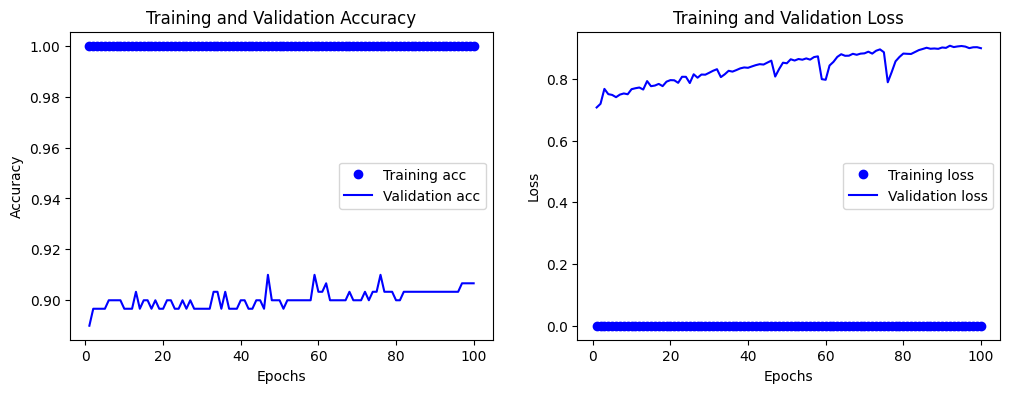

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 데이터에 대한 정확도와 손실 추출
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

# 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


10/10 [==============================] - 1s 7ms/step


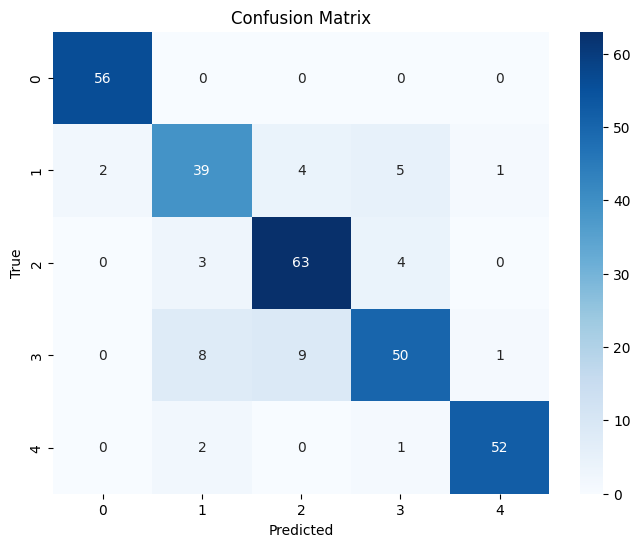

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        56
           1       0.75      0.76      0.76        51
           2       0.83      0.90      0.86        70
           3       0.83      0.74      0.78        68
           4       0.96      0.95      0.95        55

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 분류 보고서 출력 (Precision, Recall, F1-Score)
print(classification_report(y_test, y_pred_classes))

## 6-2. Epoch by Nadam

In [ ]:
# 모델 컴파일 및 학습 Nadam
model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
29/29 [==============================] - 13s 157ms/step - loss: 0.0080 - accuracy: 0.9989 - val_loss: 0.7523 - val_accuracy: 0.8800
Epoch 2/100
29/29 [==============================] - 4s 133ms/step - loss: 1.7861e-04 - accuracy: 1.0000 - val_loss: 0.6761 - val_accuracy: 0.8900
Epoch 3/100
29/29 [==============================] - 4s 139ms/step - loss: 3.1216e-05 - accuracy: 1.0000 - val_loss: 0.6473 - val_accuracy: 0.8900
Epoch 4/100
29/29 [==============================] - 3s 100ms/step - loss: 9.7343e-05 - accuracy: 1.0000 - val_loss: 0.5711 - val_accuracy: 0.9133
Epoch 5/100
29/29 [==============================] - 2s 84ms/step - loss: 2.3697e-05 - accuracy: 1.0000 - val_loss: 0.5803 - val_accuracy: 0.9067
Epoch 6/100
29/29 [==============================] - 2s 78ms/step - loss: 1.4990e-05 - accuracy: 1.0000 - val_loss: 0.5942 - val_accuracy: 0.9000
Epoch 7/100
29/29 [==============================] - 2s 68ms/step - loss: 1.1568e-05 - accuracy: 1.0000 - val_loss: 0.5994 

In [ ]:
# 평가 (테스트 및 검증 데이터셋)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

10/10 [==============================] - 0s 9ms/step - loss: 1.2149 - accuracy: 0.8333
Test Loss: 1.2148711681365967, Test Accuracy: 0.8333333134651184
10/10 [==============================] - 0s 9ms/step - loss: 0.7152 - accuracy: 0.9067
Validation Loss: 0.7152445912361145, Validation Accuracy: 0.9066666960716248


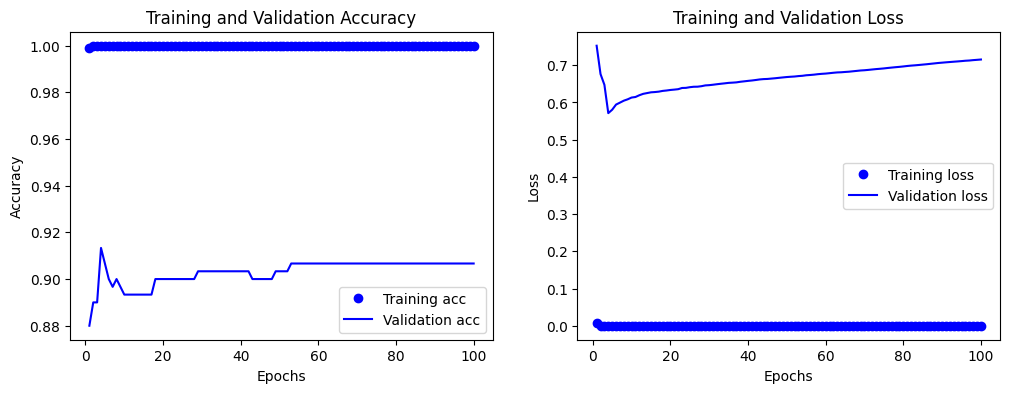

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 데이터에 대한 정확도와 손실 추출
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


10/10 [==============================] - 1s 7ms/step


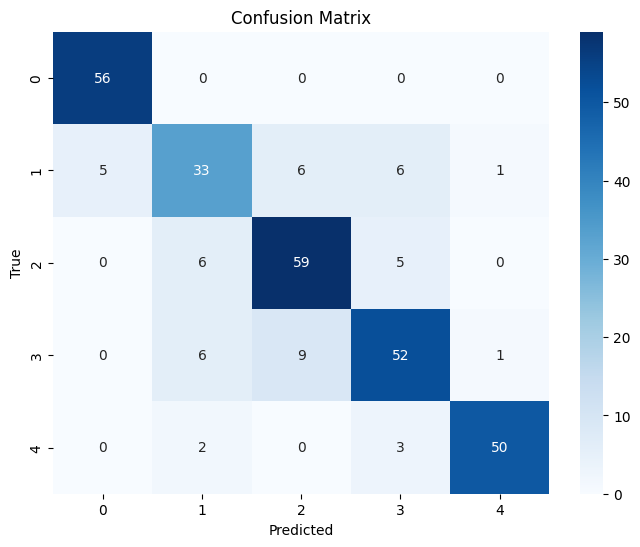

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        56
           1       0.70      0.65      0.67        51
           2       0.80      0.84      0.82        70
           3       0.79      0.76      0.78        68
           4       0.96      0.91      0.93        55

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 분류 보고서 출력 (Precision, Recall, F1-Score)
print(classification_report(y_test, y_pred_classes))

## 6-3. Epoch by RMSProp

In [ ]:
# 모델 컴파일 및 학습 RMSProp
model.compile(optimizer='RMSProp', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history1 = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
29/29 [==============================] - 15s 163ms/step - loss: 1.5671 - accuracy: 0.3000 - val_loss: 1.3930 - val_accuracy: 0.4633
Epoch 2/100
29/29 [==============================] - 3s 102ms/step - loss: 1.1063 - accuracy: 0.5833 - val_loss: 0.8247 - val_accuracy: 0.6200
Epoch 3/100
29/29 [==============================] - 2s 75ms/step - loss: 0.5999 - accuracy: 0.7733 - val_loss: 0.8851 - val_accuracy: 0.6367
Epoch 4/100
29/29 [==============================] - 1s 41ms/step - loss: 0.4122 - accuracy: 0.8744 - val_loss: 0.9977 - val_accuracy: 0.6533
Epoch 5/100
29/29 [==============================] - 1s 50ms/step - loss: 0.2616 - accuracy: 0.9278 - val_loss: 0.4290 - val_accuracy: 0.8367
Epoch 6/100
29/29 [==============================] - 1s 36ms/step - loss: 0.1904 - accuracy: 0.9544 - val_loss: 0.7172 - val_accuracy: 0.7600
Epoch 7/100
29/29 [==============================] - 1s 40ms/step - loss: 0.0777 - accuracy: 0.9811 - val_loss: 0.4695 - val_accuracy: 0.8333
Epo

In [ ]:
# 평가 (테스트 및 검증 데이터셋)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

10/10 [==============================] - 0s 8ms/step - loss: 0.8853 - accuracy: 0.8700
Test Loss: 0.8853166699409485, Test Accuracy: 0.8700000047683716
10/10 [==============================] - 0s 8ms/step - loss: 0.6626 - accuracy: 0.9067
Validation Loss: 0.662628710269928, Validation Accuracy: 0.9066666960716248


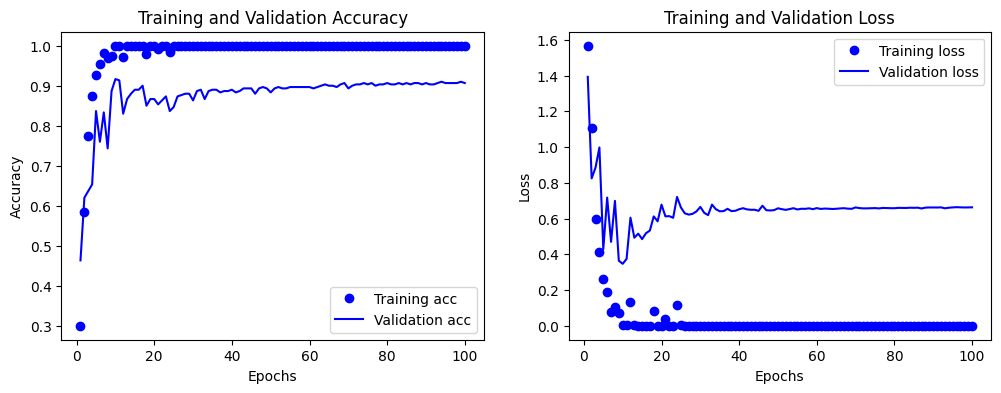

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 데이터에 대한 정확도와 손실 추출
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

# 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


10/10 [==============================] - 1s 9ms/step


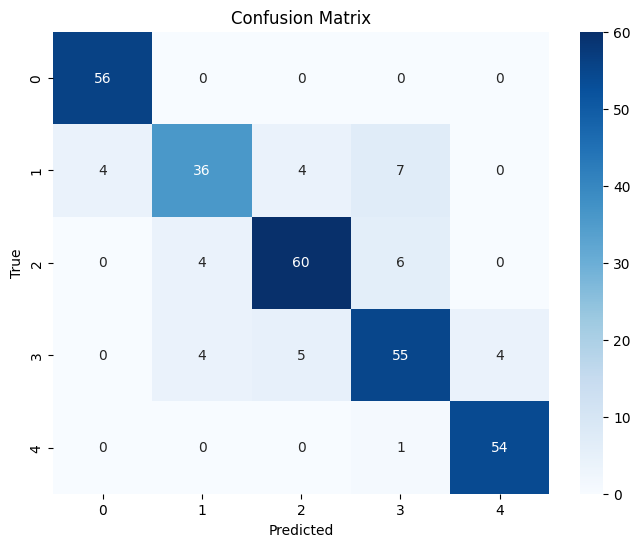

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        56
           1       0.82      0.71      0.76        51
           2       0.87      0.86      0.86        70
           3       0.80      0.81      0.80        68
           4       0.93      0.98      0.96        55

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 분류 보고서 출력 (Precision, Recall, F1-Score)
print(classification_report(y_test, y_pred_classes))